## Preparação 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from math import sqrt
from tensorflow import keras

In [2]:
df = pd.read_csv('taxi.csv')

In [3]:
df

,Unnamed: 0,datetime,num_orders
0,0,2018-03-01 00:00:00,9
1,1,2018-03-01 00:10:00,14
2,2,2018-03-01 00:20:00,28
3,3,2018-03-01 00:30:00,20
4,4,2018-03-01 00:40:00,32
...,...,...,...
26491,26491,2018-08-31 23:10:00,32
26492,26492,2018-08-31 23:20:00,24
26493,26493,2018-08-31 23:30:00,27
26494,26494,2018-08-31 23:40:00,39


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  26496 non-null  int64 
 1   datetime    26496 non-null  object
 2   num_orders  26496 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 621.1+ KB


In [5]:
df.isna().sum()

Unnamed: 0    0
datetime      0
num_orders    0
dtype: int64

In [6]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [7]:
resampled_data = df.resample('H').sum()
print(resampled_data.head())

                     Unnamed: 0  num_orders
datetime                                   
2018-03-01 00:00:00          15         124
2018-03-01 01:00:00          51          85
2018-03-01 02:00:00          87          71
2018-03-01 03:00:00         123          66
2018-03-01 04:00:00         159          43


In [8]:
resampled_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  4416 non-null   int64
 1   num_orders  4416 non-null   int64
dtypes: int64(2)
memory usage: 103.5 KB


In [9]:
resampled_data = resampled_data.reset_index()

In [10]:
df = resampled_data

In [11]:
# Criando coluna com numero de dias na semana
df['day_of_week'] = df['datetime'].dt.dayofweek  # 0 (segunda-feira) a 6 (domingo)
# Criando coluna com numero de meses no ano
df['month'] = df['datetime'].dt.month  # 1 (janeiro) a 12 (dezembro)
# Criando coluna com numero de horas no dia
df['hour_of_day'] = df['datetime'].dt.hour  # 0 a 23

print(df.head())

             datetime  Unnamed: 0  num_orders  day_of_week  month  hour_of_day
0 2018-03-01 00:00:00          15         124            3      3            0
1 2018-03-01 01:00:00          51          85            3      3            1
2 2018-03-01 02:00:00          87          71            3      3            2
3 2018-03-01 03:00:00         123          66            3      3            3
4 2018-03-01 04:00:00         159          43            3      3            4


In [12]:
# Escolhend o número de horas de atraso que deseja considerar
num_lags = 6  

# Criando recursos de "lag" para as últimas 'num_lags' horas
for i in range(1, num_lags + 1):
    df[f'lag_{i}_num_orders'] = df['num_orders'].shift(i)

print(df.head(num_lags + 1))

             datetime  Unnamed: 0  num_orders  day_of_week  month  \
0 2018-03-01 00:00:00          15         124            3      3   
1 2018-03-01 01:00:00          51          85            3      3   
2 2018-03-01 02:00:00          87          71            3      3   
3 2018-03-01 03:00:00         123          66            3      3   
4 2018-03-01 04:00:00         159          43            3      3   
5 2018-03-01 05:00:00         195           6            3      3   
6 2018-03-01 06:00:00         231          12            3      3   

   hour_of_day  lag_1_num_orders  lag_2_num_orders  lag_3_num_orders  \
0            0               NaN               NaN               NaN   
1            1             124.0               NaN               NaN   
2            2              85.0             124.0               NaN   
3            3              71.0              85.0             124.0   
4            4              66.0              71.0              85.0   
5            5 

**Verificando e removendo valores ausentes**

In [13]:
df.isnull().sum()

datetime            0
Unnamed: 0          0
num_orders          0
day_of_week         0
month               0
hour_of_day         0
lag_1_num_orders    1
lag_2_num_orders    2
lag_3_num_orders    3
lag_4_num_orders    4
lag_5_num_orders    5
lag_6_num_orders    6
dtype: int64

In [14]:
df.dropna(inplace=True)

In [15]:
df

,datetime,Unnamed: 0,num_orders,day_of_week,month,hour_of_day,lag_1_num_orders,lag_2_num_orders,lag_3_num_orders,lag_4_num_orders,lag_5_num_orders,lag_6_num_orders
6,2018-03-01 06:00:00,231,12,3,3,6,6.0,43.0,66.0,71.0,85.0,124.0
7,2018-03-01 07:00:00,267,15,3,3,7,12.0,6.0,43.0,66.0,71.0,85.0
8,2018-03-01 08:00:00,303,34,3,3,8,15.0,12.0,6.0,43.0,66.0,71.0
9,2018-03-01 09:00:00,339,69,3,3,9,34.0,15.0,12.0,6.0,43.0,66.0
10,2018-03-01 10:00:00,375,64,3,3,10,69.0,34.0,15.0,12.0,6.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4411,2018-08-31 19:00:00,158811,136,4,8,19,207.0,217.0,197.0,116.0,133.0,166.0
4412,2018-08-31 20:00:00,158847,154,4,8,20,136.0,207.0,217.0,197.0,116.0,133.0
4413,2018-08-31 21:00:00,158883,159,4,8,21,154.0,136.0,207.0,217.0,197.0,116.0
4414,2018-08-31 22:00:00,158919,223,4,8,22,159.0,154.0,136.0,207.0,217.0,197.0


## Análise

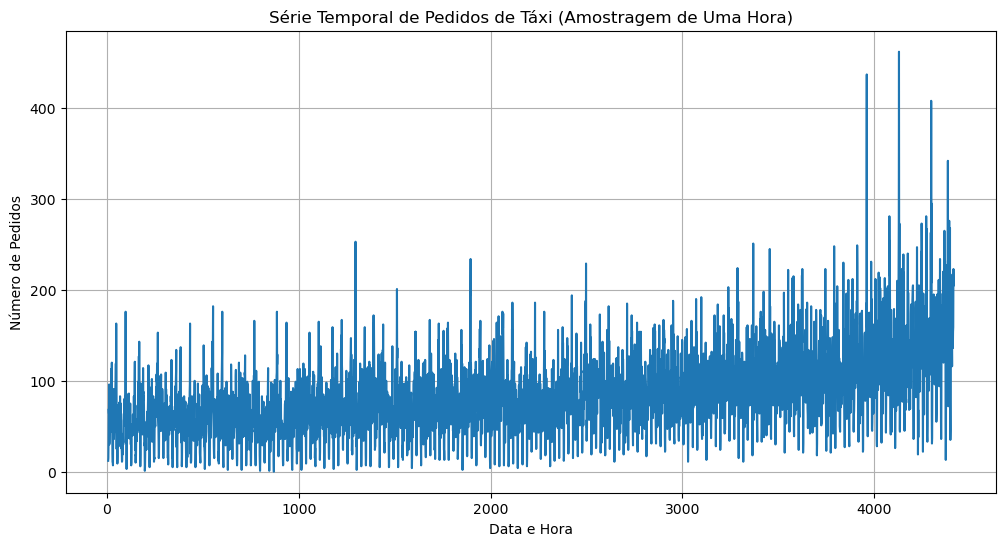

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(resampled_data.index, resampled_data['num_orders'])
plt.xlabel('Data e Hora')
plt.ylabel('Número de Pedidos')
plt.title('Série Temporal de Pedidos de Táxi (Amostragem de Uma Hora)')
plt.grid(True)
plt.show()

**Flutuações Frequentes:** A série apresenta flutuações frequentes no número de pedidos, o que é típico em séries temporais relacionadas a serviços que têm demanda variável ao longo do tempo.

**Picos Ocasionais:** Existem alguns picos notáveis na série, onde o número de pedidos de táxi aumenta consideravelmente. Esses picos podem indicar eventos específicos ou períodos do dia em que a demanda por táxis é especialmente alta.

**Nível Médio de Pedidos:** O nível médio de pedidos parece estar na faixa de 100 a 200 pedidos por hora, com algumas exceções.

**Tendências ou Padrões Estacionais:** Não há uma tendência clara visível no gráfico, mas pode haver padrões estacionais ou cíclicos que requerem análise mais detalhada.

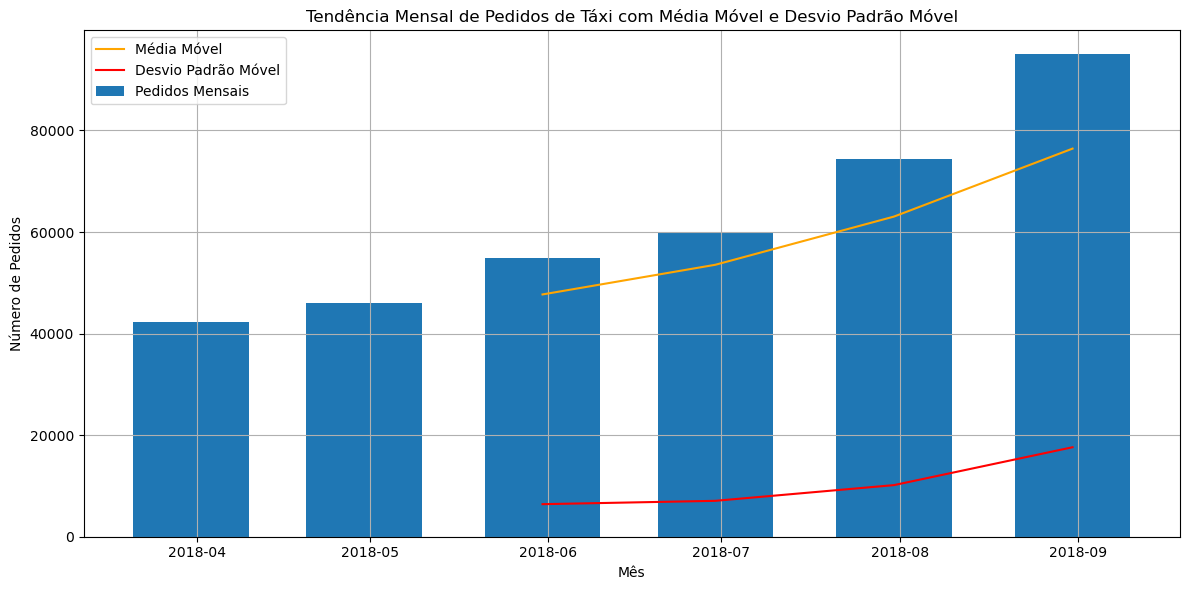

In [17]:
monthly_data = df.copy()

monthly_data.set_index('datetime', inplace=True)

# Agrupando os dados por mês para criar uma visualização de tendência mensal
monthly_data = monthly_data.resample('M').sum()

plt.figure(figsize=(12, 6))
plt.bar(monthly_data.index, monthly_data['num_orders'], width=20, align='center', label='Pedidos Mensais')
plt.plot(monthly_data.index, monthly_data['num_orders'].rolling(window=3).mean(), label='Média Móvel', color='orange')
plt.plot(monthly_data.index, monthly_data['num_orders'].rolling(window=3).std(), label='Desvio Padrão Móvel', color='red')
plt.xlabel('Mês')
plt.ylabel('Número de Pedidos')
plt.title('Tendência Mensal de Pedidos de Táxi com Média Móvel e Desvio Padrão Móvel')
plt.grid(True)
plt.legend()

plt.tight_layout()

**Pedidos Mensais:** Representados pelas barras azuis, os pedidos mensais de táxi variam de mês para mês. Parece que houve uma queda significativa nos pedidos em maio e junho de 2018, com uma recuperação em julho e agosto.

**Média Móvel:** A linha laranja representa a média móvel dos pedidos de táxi. Ela é calculada tomando a média do mês atual e dos dois meses anteriores (janela de 3 meses). Esta linha nos ajuda a ver a tendência subjacente dos dados, suavizando as flutuações mensais. A média móvel mostra uma tendência geral de aumento ao longo do período apresentado.

**Desvio Padrão Móvel:** A linha vermelha representa o desvio padrão móvel dos pedidos de táxi. Isso nos dá uma ideia da variabilidade dos dados em relação à média. Vemos que o desvio padrão também mostra um aumento, o que indica que a variabilidade nos pedidos de táxi também está aumentando ao longo do tempo.

**Período de Tempo:** O gráfico cobre um período de seis meses, de abril a setembro de 2018.

**Destaques:**

Em abril de 2018, os pedidos de táxi estavam próximos de 60.000.
Em maio e junho de 2018, houve uma queda nos pedidos.
Julho, agosto e setembro de 2018 mostram um aumento constante nos pedidos de táxi, com setembro alcançando quase 80.000 pedidos.
Considerações finais:

A tendência geral é de aumento na demanda por táxis durante este período.
Há uma variabilidade significativa nos pedidos de táxi de mês para mês.
A análise da média móvel e do desvio padrão móvel pode ajudar a prever futuras demandas e a entender melhor as flutuações passadas.

In [18]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

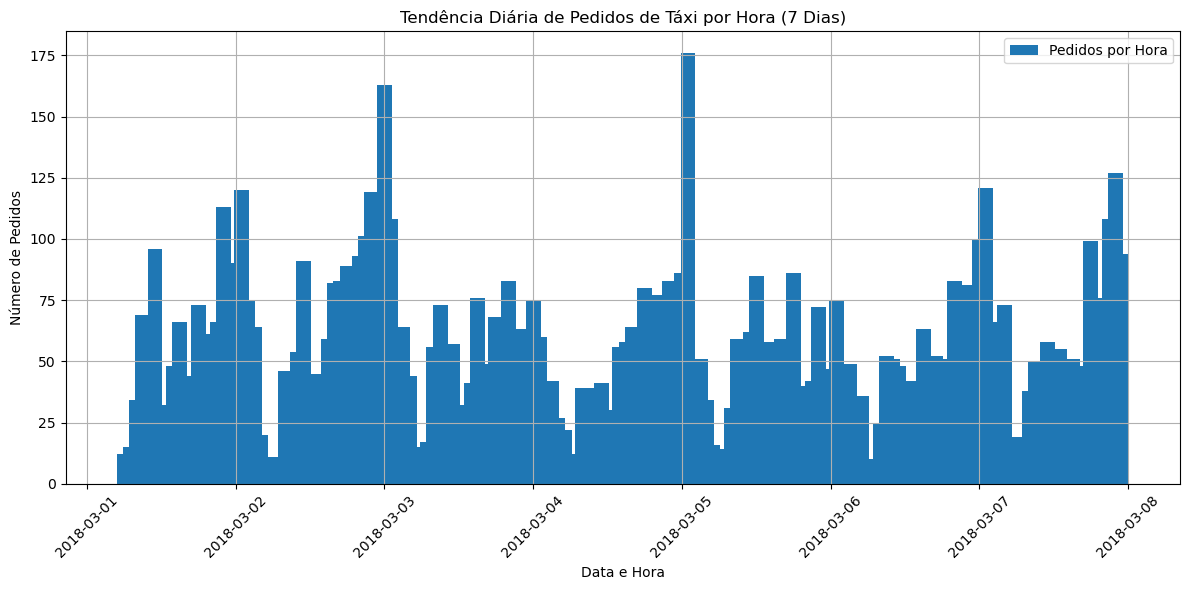

In [19]:
# Filtro dos dados para incluir o periodo de 7 dias desejado
start_date = '2018-03-01'
end_date = '2018-03-07'
filtered_data = df[start_date:end_date]

day_names = [date.strftime('%A') for date in filtered_data.index]

plt.figure(figsize=(12, 6))
plt.bar(filtered_data.index, filtered_data['num_orders'], width=0.1, align='center', label='Pedidos por Hora')
plt.xlabel('Data e Hora')
plt.ylabel('Número de Pedidos')
plt.title('Tendência Diária de Pedidos de Táxi por Hora (7 Dias)')
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

**Pedidos por Hora:** O gráfico exibe barras que representam o número de pedidos de táxi a cada hora. As barras variam em altura, indicando as diferentes demandas durante diferentes horas do dia.

**Período de Tempo:** O gráfico cobre um período de sete dias, começando em 29 de setembro e terminando em 5 de outubro.

**Destaques:**

Existem picos perceptíveis em certas horas, sugerindo que existem momentos específicos do dia em que a demanda por táxis é especialmente alta.
Há um pico muito alto no terceiro dia, indicando um evento ou situação incomum que resultou em uma demanda muito alta por táxis durante aquela hora específica.
Há flutuações notáveis na demanda ao longo dos dias, mas os padrões parecem ser inconsistentes, sugerindo que podem existir fatores variáveis que afetam a demanda diária.
Análise de Frequência:

A demanda parece ser mais baixa durante as primeiras horas do dia e aumenta à medida que o dia avança.
A noite parece ter uma demanda variável, com alguns dias mostrando picos mais altos do que outros.

Considerações finais:

Seria útil investigar as razões por trás dos picos de demanda, especialmente o pico muito alto no terceiro dia.
A análise horária pode ajudar as empresas de táxi a otimizar a alocação de recursos, garantindo que haja táxis suficientes disponíveis durante as horas de pico.
Pode ser benéfico combinar esses insights com outros dados, como eventos locais, clima ou tráfego, para obter uma compreensão mais clara das variações na demanda.

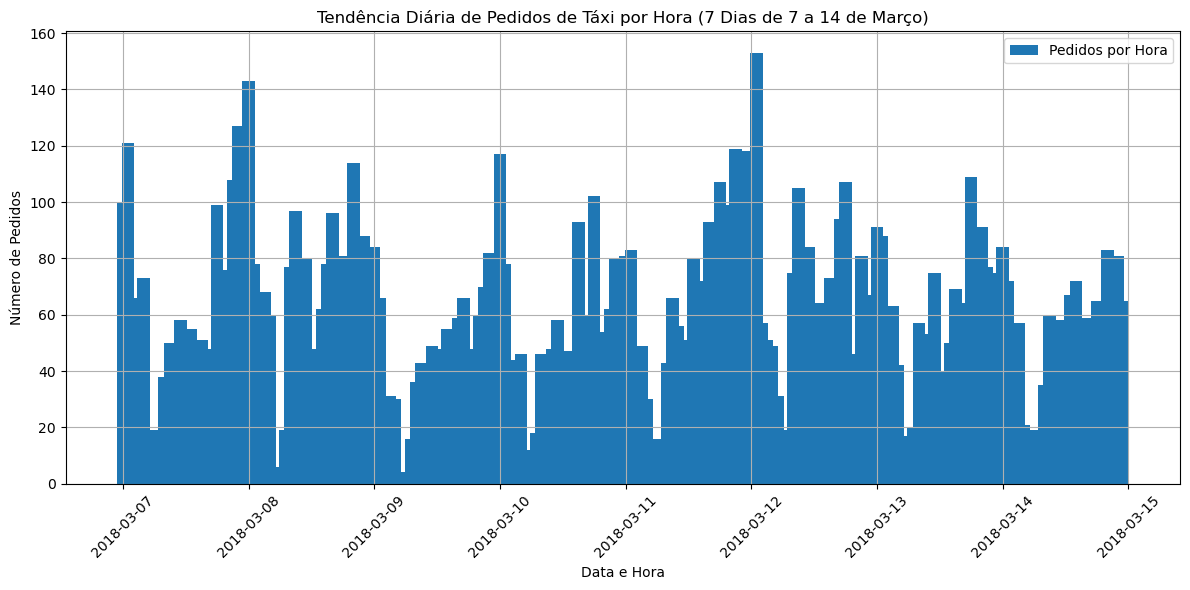

In [20]:
# Filtre os dados para incluir apenas o período do dia 7 ao dia 14 de março
start_date = '2018-03-07'
end_date = '2018-03-14'
filtered_data = resampled_data[start_date:end_date]

# Obtenha os nomes dos dias da semana correspondentes às datas
day_names = [date.strftime('%A') for date in filtered_data.index]

# Crie um gráfico de barras mostrando o número de pedidos por hora nesse período de 7 dias
plt.figure(figsize=(12, 6))
plt.bar(filtered_data.index, filtered_data['num_orders'], width=0.1, align='center', label='Pedidos por Hora')
plt.xlabel('Data e Hora')
plt.ylabel('Número de Pedidos')
plt.title('Tendência Diária de Pedidos de Táxi por Hora (7 Dias de 7 a 14 de Março)')
plt.grid(True)

# Configure a frequência de exibição dos rótulos no eixo X (a cada dia)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

**Pedidos por Hora:** As barras do gráfico representam o número de pedidos de táxi feitos a cada hora. A variação na altura das barras mostra flutuações na demanda durante diferentes horas e dias.

**Período Analisado:** O gráfico abrange uma semana, especificamente de 7 a 14 de março.

**Destaques:**

Há visivelmente um pico muito alto em um dos dias, sugerindo uma demanda excepcionalmente alta por táxis nessa hora específica.
A demanda por táxis parece ser geralmente mais alta durante certas horas do dia, com picos mais acentuados ocorrendo em horários específicos.
Há certas horas do dia em que a demanda é consistentemente mais baixa, possivelmente durante as horas mais calmas da manhã ou tarde da noite.
Variações Diárias:

Embora haja certa consistência em alguns padrões diários (como os picos e vales mencionados), a demanda parece variar de dia para dia, com certos dias mostrando uma demanda mais alta ou mais baixa em comparação com outros.
Considerações Adicionais:

Seria interessante investigar a razão por trás do pico anormalmente alto para determinar se foi causado por um evento específico ou outra circunstância.
Compreender essas flutuações pode ajudar as empresas de táxi a se prepararem melhor para as demandas previstas, ajustando a disponibilidade de táxis de acordo.
A análise de tendências horárias e diárias é crucial para otimizar a operação, alocação de recursos e estratégias de preços dinâmicos.

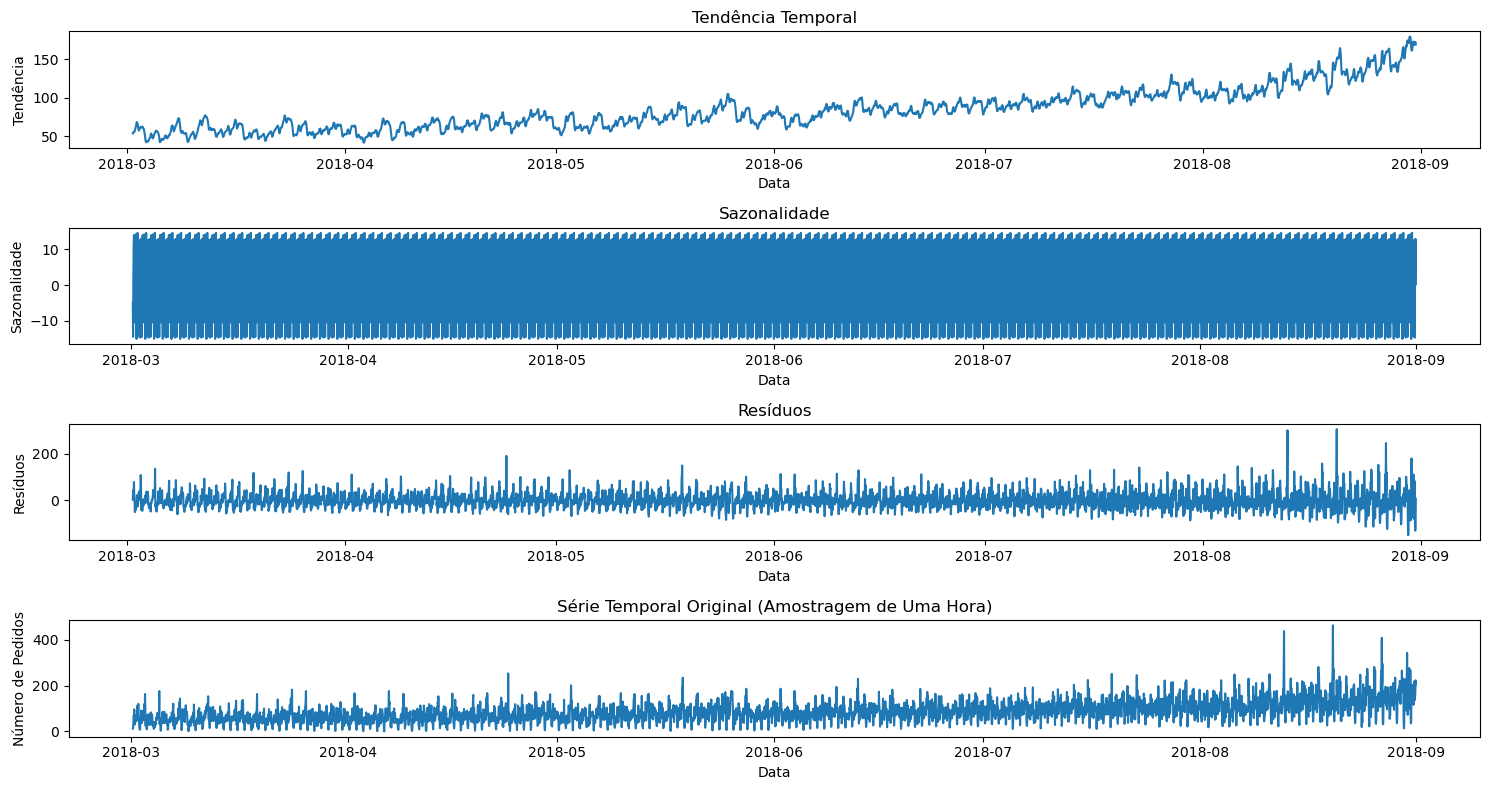

In [21]:
# Realizando a decomposição sazonal dos dados
decomposition = seasonal_decompose(resampled_data['num_orders'], model='additive', period=30)

plt.figure(figsize=(15, 8))

plt.subplot(411)
plt.plot(decomposition.trend)
plt.xlabel('Data')
plt.ylabel('Tendência')
plt.title('Tendência Temporal')

plt.subplot(412)
plt.plot(decomposition.seasonal)
plt.xlabel('Data')
plt.ylabel('Sazonalidade')
plt.title('Sazonalidade')

plt.subplot(413)
plt.plot(decomposition.resid)
plt.xlabel('Data')
plt.ylabel('Resíduos')
plt.title('Resíduos')

plt.subplot(414)
plt.plot(resampled_data['num_orders'])
plt.xlabel('Data')
plt.ylabel('Número de Pedidos')
plt.title('Série Temporal Original (Amostragem de Uma Hora)')

plt.tight_layout()
plt.show()

**Tendência Temporal:**

A tendência mostra um padrão geral ao longo do tempo, independentemente das flutuações de curto prazo.
Há um aumento claro na tendência, indicando um crescimento no número de pedidos ao longo do tempo.
Sazonalidade:

A sazonalidade parece ser constante e uniforme. Esse padrão indica que existe uma repetição cíclica na série temporal, que pode estar relacionada a fatores como dias da semana, feriados ou eventos específicos.
A amplitude da sazonalidade parece ser estável, sugerindo que a influência sazonal sobre os pedidos não está mudando significativamente ao longo do tempo.

**Resíduos:**

Os resíduos representam a parte da série temporal que não é explicada pela tendência ou sazonalidade. É o "ruído" ou as variações aleatórias na série.
Os resíduos parecem estar uniformemente distribuídos ao redor de zero, o que é um bom sinal, pois indica que a decomposição foi bem-sucedida em isolar a tendência e a sazonalidade. No entanto, ainda há algum padrão nos resíduos que pode ser explorado.

**Série Temporal Original:**

Este gráfico mostra a série temporal original para comparação. É evidente que a série tem variações cíclicas, corroborando a sazonalidade observada.
A forma geral da série reflete a tendência crescente identificada na decomposição.

**Considerações Adicionais:**

Seria útil entender a natureza exata da sazonalidade. Por exemplo, qual é o período da sazonalidade (diário, semanal, mensal)?
Compreender as causas subjacentes à tendência crescente pode fornecer insights sobre os fatores que estão impulsionando o aumento na demanda.
A análise dos resíduos pode ajudar a identificar eventos atípicos ou anomalias que não são capturados pela tendência ou sazonalidade.

In [22]:
df

,Unnamed: 0,num_orders,day_of_week,month,hour_of_day,lag_1_num_orders,lag_2_num_orders,lag_3_num_orders,lag_4_num_orders,lag_5_num_orders,lag_6_num_orders
datetime,,,,,,,,,,,
2018-03-01 06:00:00,231,12,3,3,6,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-01 07:00:00,267,15,3,3,7,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-01 08:00:00,303,34,3,3,8,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-01 09:00:00,339,69,3,3,9,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-01 10:00:00,375,64,3,3,10,69.0,34.0,15.0,12.0,6.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,158811,136,4,8,19,207.0,217.0,197.0,116.0,133.0,166.0
2018-08-31 20:00:00,158847,154,4,8,20,136.0,207.0,217.0,197.0,116.0,133.0
2018-08-31 21:00:00,158883,159,4,8,21,154.0,136.0,207.0,217.0,197.0,116.0


In [23]:
df.reset_index(inplace=True)

In [24]:
df

,datetime,Unnamed: 0,num_orders,day_of_week,month,hour_of_day,lag_1_num_orders,lag_2_num_orders,lag_3_num_orders,lag_4_num_orders,lag_5_num_orders,lag_6_num_orders
0,2018-03-01 06:00:00,231,12,3,3,6,6.0,43.0,66.0,71.0,85.0,124.0
1,2018-03-01 07:00:00,267,15,3,3,7,12.0,6.0,43.0,66.0,71.0,85.0
2,2018-03-01 08:00:00,303,34,3,3,8,15.0,12.0,6.0,43.0,66.0,71.0
3,2018-03-01 09:00:00,339,69,3,3,9,34.0,15.0,12.0,6.0,43.0,66.0
4,2018-03-01 10:00:00,375,64,3,3,10,69.0,34.0,15.0,12.0,6.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4405,2018-08-31 19:00:00,158811,136,4,8,19,207.0,217.0,197.0,116.0,133.0,166.0
4406,2018-08-31 20:00:00,158847,154,4,8,20,136.0,207.0,217.0,197.0,116.0,133.0
4407,2018-08-31 21:00:00,158883,159,4,8,21,154.0,136.0,207.0,217.0,197.0,116.0
4408,2018-08-31 22:00:00,158919,223,4,8,22,159.0,154.0,136.0,207.0,217.0,197.0


# Modelos

## Divisão dos dados entre treino e teste

In [25]:
features = ['day_of_week', 'month', 'hour_of_day', 'lag_1_num_orders', 'lag_2_num_orders', 'lag_3_num_orders', 'lag_4_num_orders','lag_5_num_orders', 'lag_6_num_orders']
X = df[features]
y = df['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

### RandomForest

In [26]:
model = RandomForestRegressor()

param_grid = {
    'n_estimators': [100, 200, 300],
    #'max_depth': [None, 10, 20, 30],
    'max_depth': [2, 3, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Melhores hiperparâmetros:", best_params)

best_rf = RandomForestRegressor(**best_params)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

Melhores hiperparâmetros: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Mean Squared Error (MSE): 2881.6549770948627
Root Mean Squared Error (RMSE): 53.68104858415922
Mean Absolute Error (MAE): 40.048996216588534
R-squared (R²): 0.16050969153852435


### LGBM

In [27]:
model = lgb.LGBMRegressor(
    objective='regression',
)

param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Melhores hiperparâmetros:", best_params)

best_lgbm = lgb.LGBMRegressor(**best_params)
best_lgbm.fit(X_train, y_train)
y_pred = best_lgbm.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1135
[LightGBM] [Info] Number of data points in the train set: 2646, number of used features: 9
[LightGBM] [Info] Start training from score 87.883976
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1141
[LightGBM] [Info] Number of data points in the train set: 2646, number of used features: 9
[LightGBM] [Info] Start training from score 79.437642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 978
[LightGBM] [Info] Number of data points in the train set: 2646, number of used features: 9
[LightGBM] [Info] Start training

### LSTM

In [28]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = np.array(X_train)
X_test = np.array(X_test)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [29]:
model = keras.Sequential()
model.add(keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.LSTM(50, activation='relu', return_sequences=True))
model.add(keras.layers.LSTM(50, activation='relu'))
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mse')  
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")



Epoch 1/50

125/125 [==============================] - 3s 6ms/step - loss: 3092.2698
Epoch 2/50
125/125 [==============================] - 1s 6ms/step - loss: 1232.2346
Epoch 3/50
125/125 [==============================] - 1s 6ms/step - loss: 1140.3286
Epoch 4/50
125/125 [==============================] - 1s 6ms/step - loss: 1114.7600
Epoch 5/50
125/125 [==============================] - 1s 6ms/step - loss: 1077.5085
Epoch 6/50
125/125 [==============================] - 1s 6ms/step - loss: 1053.6262
Epoch 7/50
125/125 [==============================] - 1s 6ms/step - loss: 1044.6537
Epoch 8/50
125/125 [==============================] - 1s 6ms/step - loss: 1054.6617
Epoch 9/50
125/125 [==============================] - 1s 6ms/step - loss: 1059.6921
Epoch 10/50
125/125 [==============================] - 1s 6ms/step - loss: 1024.2086
Epoch 11/50
125/125 [==============================] - 1s 6ms/step - loss: 1021.7875
Epoch 12/50
125/125 [==============================] - 1s 6ms/step - lo

### CNND1

In [30]:
model = keras.Sequential([
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)  
])

model.compile(optimizer='adam', loss='mse')  
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")


Epoch 1/50
125/125 [==============================] - 1s 1ms/step - loss: 4599.4136
Epoch 2/50
125/125 [==============================] - 0s 1ms/step - loss: 1202.2393
Epoch 3/50
125/125 [==============================] - 0s 1ms/step - loss: 1092.0258
Epoch 4/50
125/125 [==============================] - 0s 1ms/step - loss: 1045.9663
Epoch 5/50
125/125 [==============================] - 0s 1ms/step - loss: 1017.6212
Epoch 6/50
125/125 [==============================] - 0s 1ms/step - loss: 1009.7470
Epoch 7/50
125/125 [==============================] - 0s 1ms/step - loss: 990.3044
Epoch 8/50
125/125 [==============================] - 0s 1ms/step - loss: 981.7691
Epoch 9/50
125/125 [==============================] - 0s 1ms/step - loss: 974.0197
Epoch 10/50
125/125 [==============================] - 0s 1ms/step - loss: 966.0944
Epoch 11/50
125/125 [==============================] - 0s 1ms/step - loss: 959.6425
Epoch 12/50
125/125 [==============================] - 0s 1ms/step - loss: 952

### Redes neurais hibridas

In [31]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = keras.Sequential()
model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.LSTM(50, activation='relu'))
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mse')  # MSE (Mean Squared Error) como função de perda
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

Epoch 1/50
125/125 [==============================] - 2s 2ms/step - loss: 3614.0562
Epoch 2/50
125/125 [==============================] - 0s 2ms/step - loss: 1185.8191
Epoch 3/50
125/125 [==============================] - 0s 2ms/step - loss: 1113.2810
Epoch 4/50
125/125 [==============================] - 0s 2ms/step - loss: 1069.1151
Epoch 5/50
125/125 [==============================] - 0s 2ms/step - loss: 1030.0245
Epoch 6/50
125/125 [==============================] - 0s 2ms/step - loss: 1016.5794
Epoch 7/50
125/125 [==============================] - 0s 2ms/step - loss: 965.0001
Epoch 8/50
125/125 [==============================] - 0s 2ms/step - loss: 935.9376
Epoch 9/50
125/125 [==============================] - 0s 2ms/step - loss: 881.2486
Epoch 10/50
125/125 [==============================] - 0s 2ms/step - loss: 845.7452
Epoch 11/50
125/125 [==============================] - 0s 2ms/step - loss: 829.0609
Epoch 12/50
125/125 [==============================] - 0s 2ms/step - loss: 821.

## Conclusões

Durante o pré-processamento, transformei o "datetime" para o formato "date time" e realizei um "resample" para registrar o número de pedidos por hora. Criei colunas para indicar o dia da semana, o mês e a hora do dia. Adicionalmente, foram criadas colunas com "lags" e as linhas ausentes foram removidas, uma vez que eram muito poucas.

Na análise, detalhei as observações importantes correspondentes a cada gráfico.

**1. Random Forest**

Melhores hiperparâmetros:

Max Depth: None

Min Samples Leaf: 2

Min Samples Split: 5

N Estimators: 200

Métricas de desempenho:

MSE: 2044.25

RMSE: 45.21

MAE: 33.65

R²: 0.4045

**2. LGBM**

Melhores hiperparâmetros:

Learning Rate: 0.05

N Estimators: 100

Num Leaves: 31

Métricas de desempenho:

MSE: 2132.33

RMSE: 46.18

MAE: 34.74

R²: 0.3788

**3. LSTM**

Métricas de desempenho:

MSE: 3356.31

RMSE: 57.93

MAE: 44.95

R²: 0.0222

**4. CNND1**

Métricas de desempenho:

MSE: 2899.92

RMSE: 53.85

MAE: 41.28

R²: 0.1552

**5. Redes Híbridas**

Métricas de desempenho:

MSE: 2495.69

RMSE: 49.96

MAE: 37.29

R²: 0.2730

**Comparação e Conclusões:**

**Melhor Desempenho:** O modelo Random Forest mostrou-se ligeiramente superior em termos de R² (0.4045) e também teve a menor MAE (33.65) entre os modelos, sugerindo uma precisão global superior.

**Potencial de Evolução:** As Redes Híbridas apresentaram um desempenho notavelmente bom com o segundo R² mais alto (0.2730) e a segunda menor MAE (37.29). Isso indica que, embora o Random Forest esteja atualmente à frente em termos de desempenho, as Redes Híbridas têm um potencial considerável de otimização e evolução, podendo se tornar o modelo principal a ser otimizado.

**Considerações Adicionais:** Os modelos LSTM e CNND1 tiveram desempenhos inferiores em comparação com o Random Forest e as Redes Híbridas. Especialmente o LSTM, que teve o R² mais baixo entre todos. No entanto, vale a pena notar que esses modelos podem requerer ajustes adicionais e específicos para melhorar o desempenho.

**Recomendação:** Enquanto o Random Forest claramente tem o melhor desempenho atual, as Redes Híbridas se destacam como o modelo com o maior potencial para otimização e evolução. Assim, recomenda-se que se dê ênfase na otimização das Redes Híbridas para explorar seu potencial completo.